In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [2]:
from scipy.constants import pi, speed_of_light, elementary_charge, electron_mass, hbar

me_SI = electron_mass
hbar_SI = hbar   
e_SI = elementary_charge
c_SI = speed_of_light

meV = e_SI * 1e-3
nm = 1e-9                    
ps = 1e-12                    

c = c_SI * ps / nm           
hbar_meV_ps = hbar_SI / (meV * ps)  
me = me_SI * c_SI**2 / meV / c**2    

hbar = hbar_meV_ps
m = me
omega = 2 / hbar
vQD = 15

x_min = -25
x_max = 110
t_min = 0
t_max = 50

x0 = 0
x1 = 75
t0 = 0
t1 = 2

In [3]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS backend for Apple GPU acceleration!")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using cuda")
else:
    device = torch.device("cpu")
    print("Using CPU instead.")

Using cuda


# PINN

In [4]:
class PINN(nn.Module):
  def __init__(self, layers):
    super(PINN, self).__init__()
    self.hidden_layers = nn.ModuleList()
    for units in layers[1:-1]:
      self.hidden_layers.append(nn.Linear(in_features=layers[0], out_features=units))
      layers[0] = units

    self.output_layer = nn.Linear(layers[-2], layers[-1])

  def forward(self, inputs):
    x, t = inputs
    X = torch.stack((x, t), dim=1)

    for layer in self.hidden_layers:
      X = layer(X)
      X = torch.tanh(X)

    output = self.output_layer(X)
    psi_real = output[:, 0]
    psi_img = output[:, 1]

    return psi_real, psi_img

In [5]:
layers = [2, 512, 512, 512, 512, 512, 512, 2]

In [6]:
n_collocation = 25000
n_initial = 10000
n_boundary = 1000

In [7]:
def generator():
    x_collocation = np.random.uniform(x_min, x_max, n_collocation)
    t_collocation = np.random.uniform(t_min, t_max, n_collocation)
    
    x_initial = np.random.uniform(x_min, x_max, n_initial)
    t_initial = np.full(n_initial, t_min)
    
    x_boundary = np.concatenate([np.full(n_boundary // 2, x_min), np.full(n_boundary // 2, x_max)])
    t_boundary = np.random.uniform(t_min, t_max, n_boundary)
    
    x_collocation_torch = torch.from_numpy(x_collocation).float().to(device)
    t_collocation_torch = torch.from_numpy(t_collocation).float().to(device)
    
    x_initial_torch  = torch.from_numpy(x_initial).float().to(device)
    t_initial_torch  = torch.from_numpy(t_initial).float().to(device)
    
    x_boundary_torch = torch.from_numpy(x_boundary).float().to(device)
    t_boundary_torch = torch.from_numpy(t_boundary).float().to(device)

    return x_collocation_torch, t_collocation_torch, x_initial_torch, t_initial_torch, x_boundary_torch, t_boundary_torch


In [8]:
model = PINN(layers)
model.to(device)

PINN(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=2, out_features=512, bias=True)
    (1-5): 5 x Linear(in_features=512, out_features=512, bias=True)
  )
  (output_layer): Linear(in_features=512, out_features=2, bias=True)
)

In [9]:
optimizer = torch.optim.Adam(
  model.parameters(),
  lr=0.001,
  betas=(0.9, 0.9)
)

decay_rate = 0.9
steps = 2000

def exp_decay(step):
  return decay_rate ** (step / steps)

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=exp_decay)

In [10]:
def loss_function(x_collocation_torch, t_collocation_torch, x_initial_torch, t_initial_torch, x_boundary_torch, t_boundary_torch):
    #pde loss
    x_collocation_torch = x_collocation_torch.clone().requires_grad_(True)
    t_collocation_torch = t_collocation_torch.clone().requires_grad_(True)
    
    u, v = model((x_collocation_torch, t_collocation_torch))
    
    du_dt = torch.autograd.grad(u, t_collocation_torch, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    du_dx = torch.autograd.grad(u, x_collocation_torch, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    d2u_dx2 = torch.autograd.grad(du_dx, x_collocation_torch, grad_outputs=torch.ones_like(du_dx), create_graph=True)[0]
    
    dv_dt = torch.autograd.grad(v, t_collocation_torch, grad_outputs=torch.ones_like(v), create_graph=True)[0]
    dv_dx = torch.autograd.grad(v, x_collocation_torch, grad_outputs=torch.ones_like(v), create_graph=True)[0]
    d2v_dx2 = torch.autograd.grad(dv_dx, x_collocation_torch, grad_outputs=torch.ones_like(dv_dx), create_graph=True)[0]
    
    xqd_arr = torch.where(t_collocation_torch < t1, x0, torch.where(t_collocation_torch < t1 + (x1 - x0) / vQD, x0 + vQD * (t_collocation_torch - t1), x1))
    
    real = -hbar * dv_dt + ((hbar ** 2) / (2 * m)) * d2u_dx2 - 0.5 * m * (omega ** 2) * ((x_collocation_torch - xqd_arr) ** 2) * u
    img = hbar * du_dt + ((hbar ** 2) / (2 * m)) * d2v_dx2 - 0.5 * m * (omega ** 2) * ((x_collocation_torch - xqd_arr) ** 2) * v
    
    physics_loss = torch.mean(real ** 2 + img ** 2)
    
    
    
    
    #initial condition loss
    u_i, v_i = model((x_initial_torch, t_initial_torch))
    
    psi_initial_actual = (((m * omega) / (np.pi * hbar)) ** 0.25) * torch.exp(((-m * omega) / (2 * hbar)) * (x_initial_torch ** 2))
    initial_condition_loss = torch.mean((u_i - psi_initial_actual) ** 2) + torch.mean((v_i - 0) ** 2)
    
    
    
    
    #boundary condition loss
    u_b, v_b = model((x_boundary_torch, t_boundary_torch))
    boundary_condition_loss = torch.mean(u_b ** 2) + torch.mean(v_b ** 2)
    
    return physics_loss, initial_condition_loss, boundary_condition_loss

In [11]:
epochs = 60000
history = []

for epoch in range(1, epochs+1):
  optimizer.zero_grad()

  physics_loss, initial_condition_loss, boundary_condition_loss = loss_function(*generator())
  total_loss = 10 * physics_loss + 10 * initial_condition_loss + 0.01 * boundary_condition_loss

  total_loss.backward()
  optimizer.step()
  scheduler.step()

  history.append({"total_loss": total_loss.item() ,"physics_loss": physics_loss.item(), "initial_condition_loss": initial_condition_loss.item(), "boundary_condition_loss": boundary_condition_loss.item()})

  if epoch % 600 == 0:
    print(f"Epoch {epoch}/{epochs}")
    print(f"Total loss: {total_loss.item():.4e}")
    print(f"Physics loss: {physics_loss.item():.4e}")
    print(f"Initial condition loss: {initial_condition_loss.item():.4e}")
    print(f"Boundary condition loss: {boundary_condition_loss.item():.4e}")
    print("-" * 50)
    

Epoch 600/60000
Total loss: 1.0654e-01
Physics loss: 3.1839e-03
Initial condition loss: 7.4698e-03
Boundary condition loss: 3.9986e-07
--------------------------------------------------
Epoch 1200/60000
Total loss: 2.5223e-01
Physics loss: 1.7911e-02
Initial condition loss: 7.3112e-03
Boundary condition loss: 3.3244e-06
--------------------------------------------------
Epoch 1800/60000
Total loss: 7.6149e-02
Physics loss: 2.3556e-04
Initial condition loss: 7.3793e-03
Boundary condition loss: 2.6653e-08
--------------------------------------------------
Epoch 2400/60000
Total loss: 8.3228e-02
Physics loss: 4.4141e-04
Initial condition loss: 7.8814e-03
Boundary condition loss: 4.8350e-08
--------------------------------------------------
Epoch 3000/60000
Total loss: 7.5387e-02
Physics loss: 3.4125e-04
Initial condition loss: 7.1974e-03
Boundary condition loss: 2.6832e-08
--------------------------------------------------
Epoch 3600/60000
Total loss: 7.5282e-02
Physics loss: 2.6165e-04
I

In [12]:
total_loss_history = [record['total_loss'] for record in history]
physics_loss_history = [record['physics_loss'] for record in history]
initial_condition_loss_history = [record['initial_condition_loss'] for record in history]
boundary_condition_loss_history = [record['boundary_condition_loss'] for record in history]

epochs_range = range(1, epochs + 1)

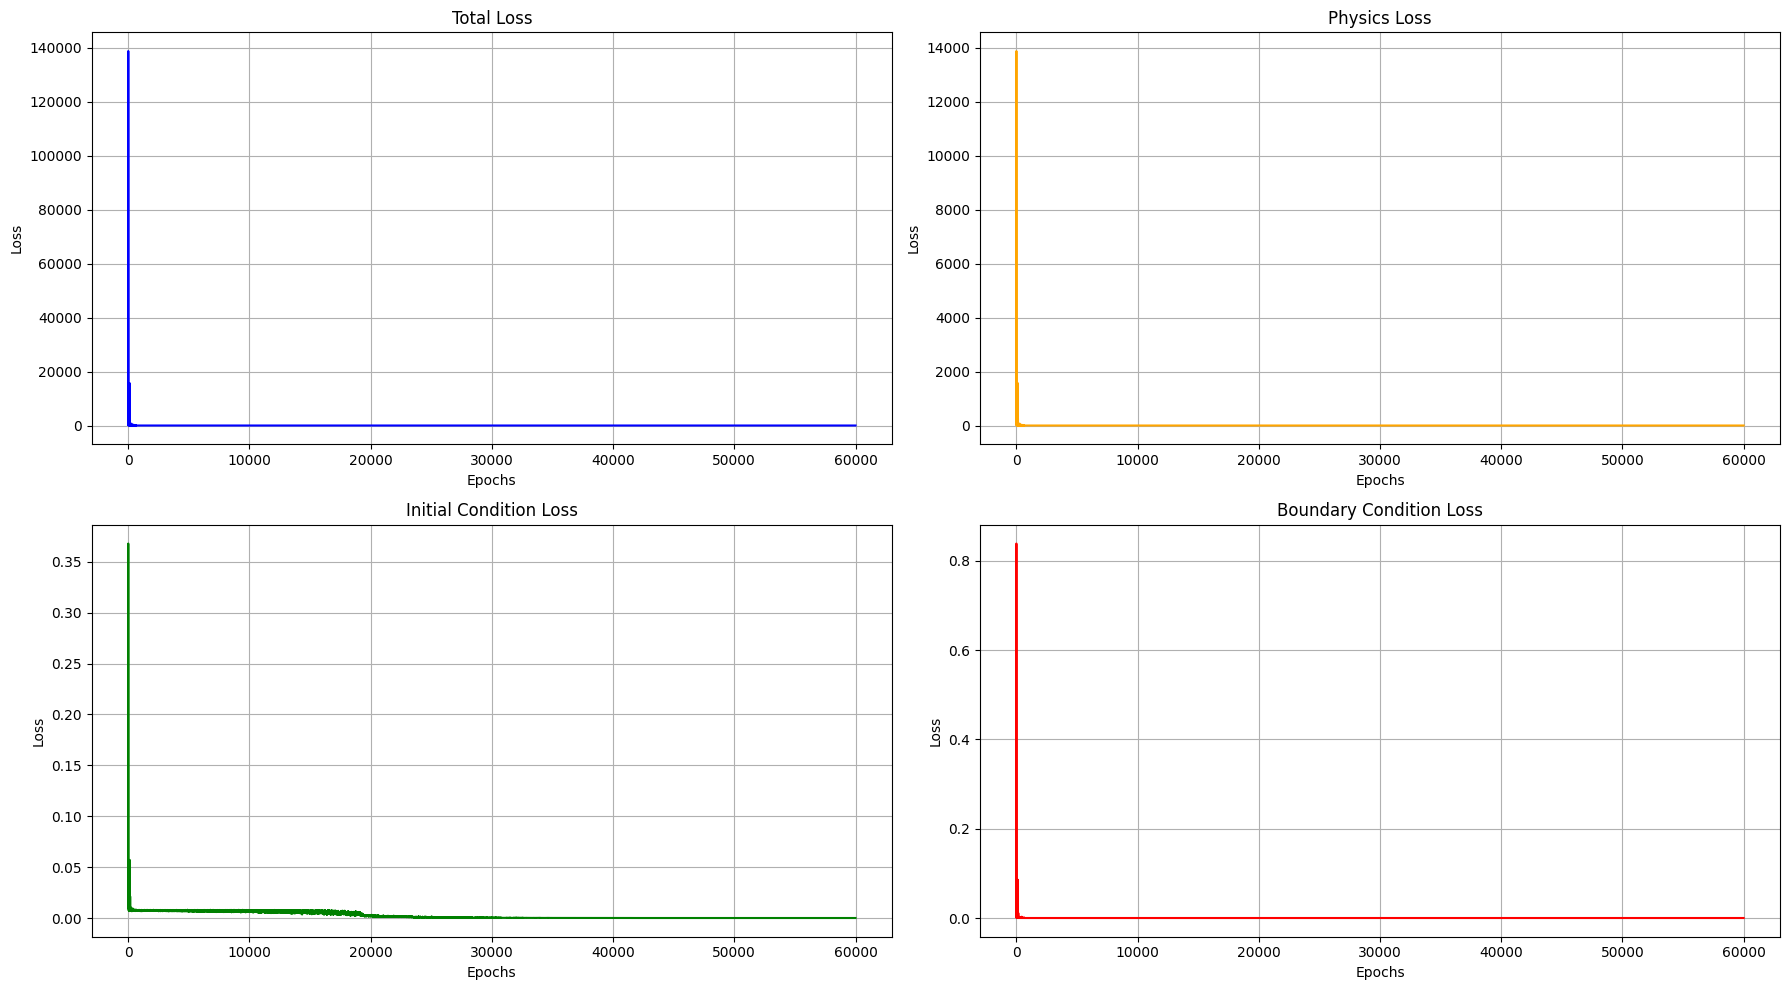

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(18, 10))

# Total Loss
axs[0, 0].plot(epochs_range, total_loss_history, color='blue')
axs[0, 0].set_title('Total Loss')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].grid(True)

# Physics Loss
axs[0, 1].plot(epochs_range, physics_loss_history, color='orange')
axs[0, 1].set_title('Physics Loss')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].grid(True)

# Initial Condition Loss
axs[1, 0].plot(epochs_range, initial_condition_loss_history, color='green')
axs[1, 0].set_title('Initial Condition Loss')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].grid(True)

# Boundary Condition Loss
axs[1, 1].plot(epochs_range, boundary_condition_loss_history, color='red')
axs[1, 1].set_title('Boundary Condition Loss')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Loss')
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

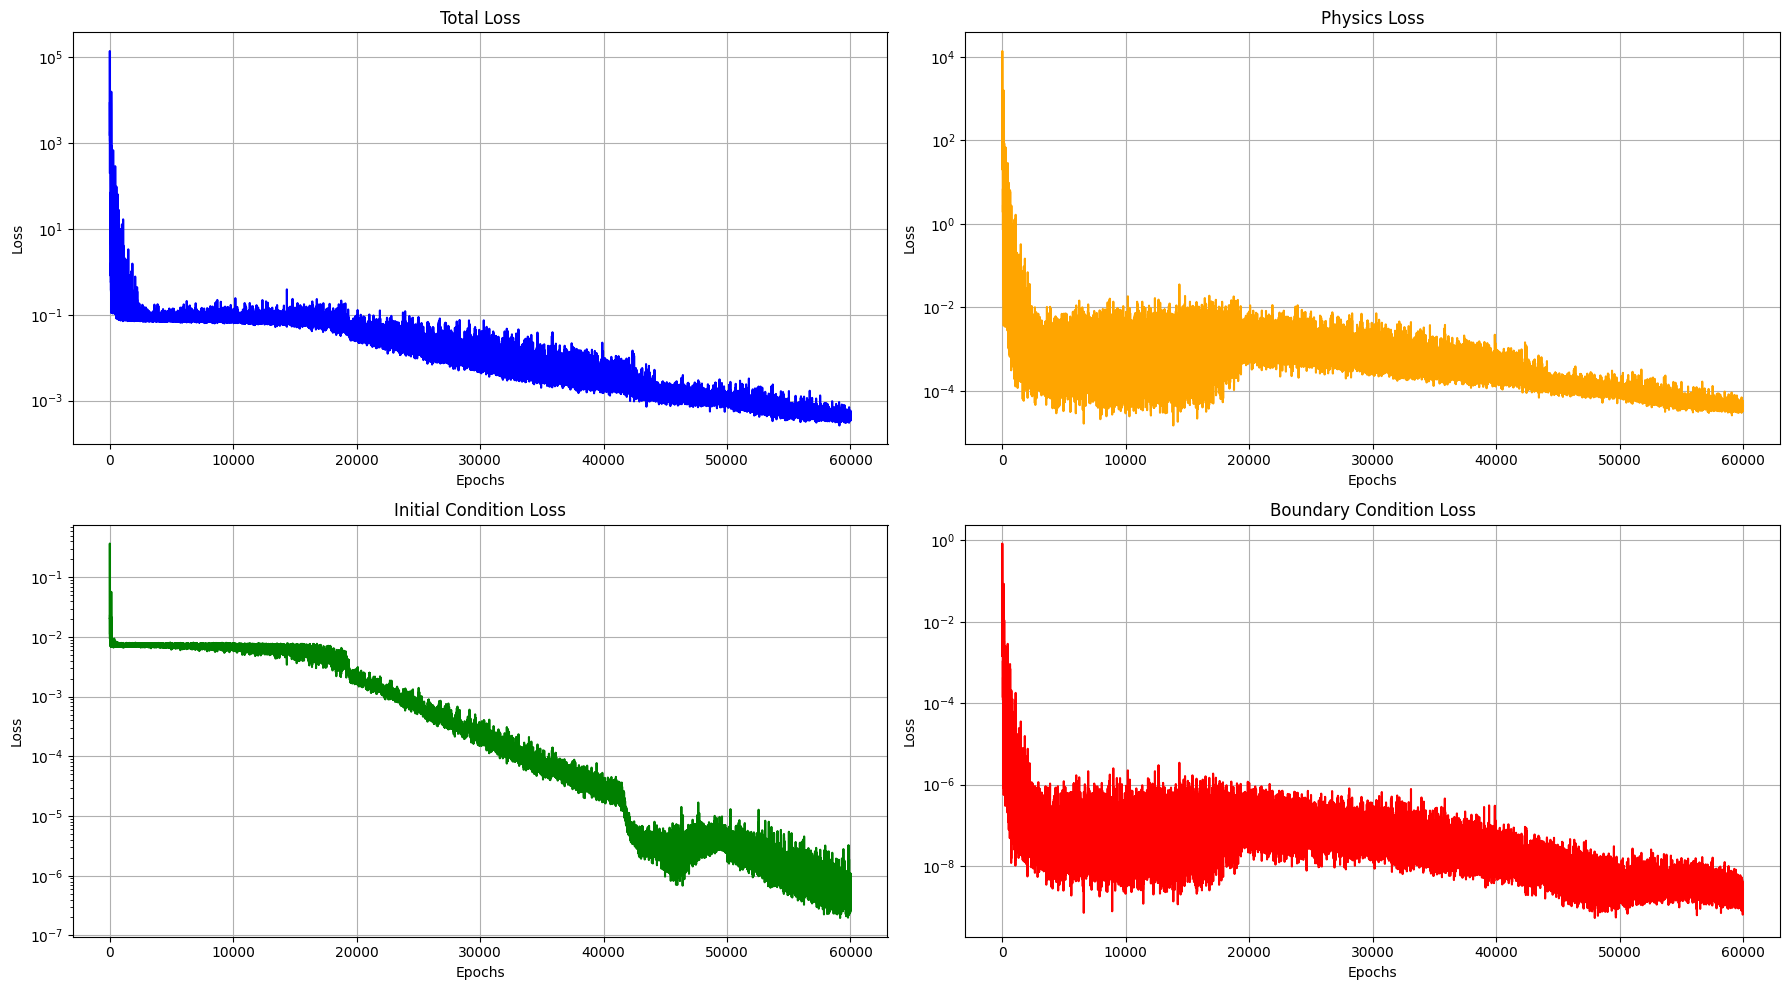

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(18, 10))

# Total Loss
axs[0, 0].plot(epochs_range, total_loss_history, color='blue')
axs[0, 0].set_title('Total Loss')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].grid(True)
axs[0, 0].set_yscale("log")

# Physics Loss
axs[0, 1].plot(epochs_range, physics_loss_history, color='orange')
axs[0, 1].set_title('Physics Loss')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].grid(True)
axs[0, 1].set_yscale("log")

# Initial Condition Loss
axs[1, 0].plot(epochs_range, initial_condition_loss_history, color='green')
axs[1, 0].set_title('Initial Condition Loss')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].grid(True)
axs[1, 0].set_yscale("log")

# Boundary Condition Loss
axs[1, 1].plot(epochs_range, boundary_condition_loss_history, color='red')
axs[1, 1].set_title('Boundary Condition Loss')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Loss')
axs[1, 1].grid(True)
axs[1, 1].set_yscale("log")

plt.tight_layout()
plt.show()

# Testing

In [15]:
Nx = 600
Nt = 600

x_values = np.linspace(x_min, x_max, Nx)
t_values = np.linspace(t_min, t_max, Nt)

In [16]:
x_values_torch = torch.from_numpy(x_values).float().to(device)
t_values_torch = torch.from_numpy(t_values).float().to(device)

x_grid, t_grid = torch.meshgrid(x_values_torch, t_values_torch, indexing="ij")

x_flat = torch.reshape(x_grid, [-1])
t_flat = torch.reshape(t_grid, [-1])

psi_real_pinn, psi_img_pinn = model((x_flat, t_flat))

psi_real_pinn = torch.reshape(psi_real_pinn, (Nx, Nt))
psi_img_pinn = torch.reshape(psi_img_pinn, (Nx, Nt))

psi_real_pinn = psi_real_pinn.detach().cpu().numpy()
psi_img_pinn = psi_img_pinn.detach().cpu().numpy()

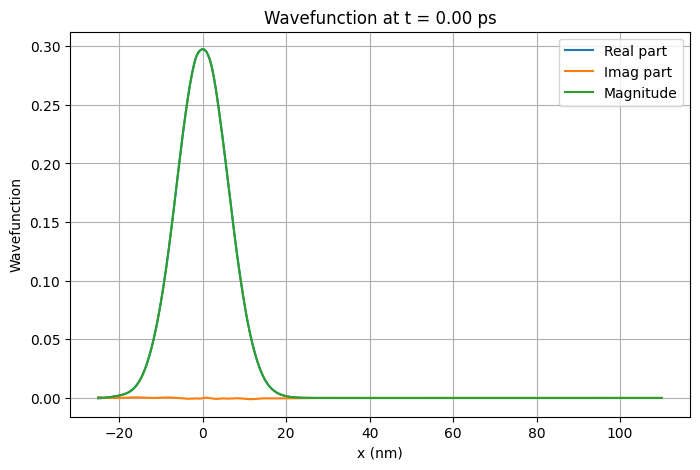

In [17]:
time_index = 0
time_chosen = t_values[time_index]

psi_real_slice_pinn = psi_real_pinn[:, time_index]
psi_img_slice_pinn = psi_img_pinn[:, time_index]

psi_mag_slice_pinn = np.sqrt(psi_real_slice_pinn**2 + psi_img_slice_pinn**2)

plt.figure(figsize=(8,5))
plt.plot(x_values, psi_real_slice_pinn, label='Real part')
plt.plot(x_values, psi_img_slice_pinn, label='Imag part')
plt.plot(x_values, psi_mag_slice_pinn, label='Magnitude')
plt.title(f'Wavefunction at t = {time_chosen:.2f} ps')
plt.xlabel('x (nm)')
plt.ylabel('Wavefunction')
plt.legend()
plt.grid(True)
plt.show()

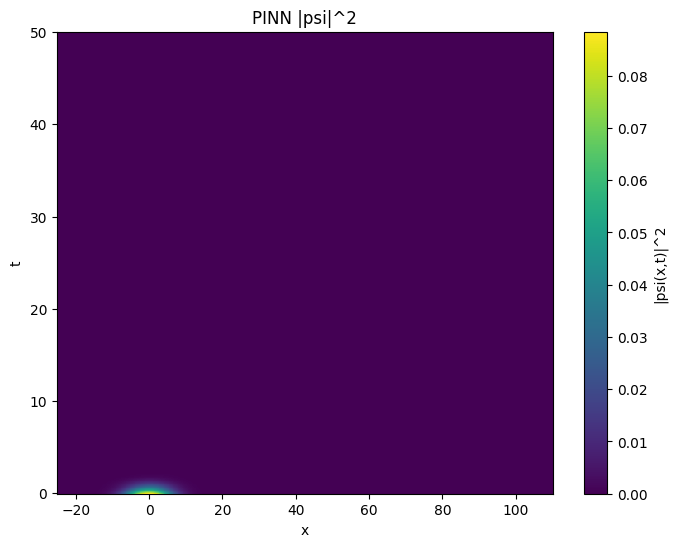

In [18]:
plt.figure(figsize=(8, 6))
psi_sq = psi_real_pinn ** 2 + psi_img_pinn ** 2

plt.pcolormesh(x_values, t_values, psi_sq.transpose(), shading="auto")
plt.colorbar(label='|psi(x,t)|^2')
plt.xlabel('x')
plt.ylabel('t')
plt.title('PINN |psi|^2')
plt.show()

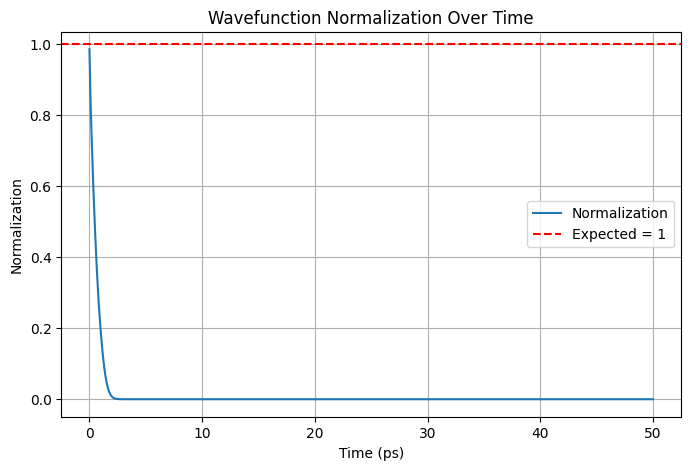

In [19]:
from scipy.integrate import simpson

norms = []

for i in range(600):
    psi_sq = psi_real_pinn[:, i] ** 2 + psi_img_pinn[:, i] ** 2
    normalization = simpson(psi_sq, x=x_values)
    norms.append(normalization)

plt.figure(figsize=(8,5))
plt.plot(t_values, norms, '-', label='Normalization')
plt.axhline(1.0, color='red', linestyle='--', label='Expected = 1')
plt.xlabel('Time (ps)')
plt.ylabel('Normalization')
plt.title('Wavefunction Normalization Over Time')
plt.legend()
plt.grid(True)
plt.show()